## Synthetic Experiments

This notebook produces Figures 11 and 12.

### Imports and plot params

In [1]:
import os
import numpy as np
import json
import rbo
from statistics import mean,stdev

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amsfonts,geometry}'
mpl.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams.update({
    'font.family':'serif',
    "font.serif": ["Computer Modern Roman"],
    "text.usetex": True,
    "font.size": 35,
    "figure.figsize":(33,18),
    "lines.markersize": 10
})
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

In [2]:
label_mapping={'baseline':r'$\textsc{Target}$',
               'human only':r'$\textsc{Human Only}$',
               'llm 0.05':r'$\textsc{Llm 0.05}$',
               'llm 0.1':r'$\textsc{Llm 0.1}$',
               'llm 0.3':r'$\textsc{Llm 0.3}$',
               'ppr 0.05':r'$\textsc{Ppr 0.05}$',
               'ppr 0.1':r'$\textsc{Ppr 0.1}$',
               'ppr 0.3':r'$\textsc{Ppr 0.3}$'}

color_mapping={'baseline':'black',
               'human only':'cadetblue',
               'llm 0.05':'darkgray',
               'llm 0.1':'darkgray',
               'llm 0.3':'darkgray',
               'ppr 0.05':'firebrick',
               'ppr 0.1':'goldenrod',
               'ppr 0.3':'mediumblue'}

marker_mapping={'baseline':'*',
               'human only':'^',
               'llm 0.05':'o',
               'llm 0.1':'s',
               'llm 0.3':'X',
               'ppr 0.05':'o',
               'ppr 0.1':'s',
               'ppr 0.3':'X'}

linestyles={'baseline':'*',
               'human only':'^',
               'llm 0.05':':',
               'llm 0.1':'-.',
               'llm 0.3':'--',
               'ppr 0.05':'o',
               'ppr 0.1':'s',
               'ppr 0.3':'X'}

methods=['baseline',
         'ppr 0.05',
         'ppr 0.1',
         'ppr 0.3',
         'human only',
         'llm 0.05',
         'llm 0.1',
         'llm 0.3',
         ]

### Compute metrics

In [3]:
class Result:
    def __init__(self, k,n,alpha, folder):
        path=folder+'k'+str(k)+'_'+str(n)+'_'+str(alpha).split('.')[1]+'_ranksets.json'
        ranksets=[]
        with open(path) as f:
            for line in f:
                l = json.loads(line)
                ranksets.append(l)
        self.ranksets=ranksets
        self.iterations=len(self.ranksets)

        path = folder +'k'+str(k)+'_'+str(n)+'_'+str(alpha).split('.')[1]+'_thetas.json'
        thetas = []
        with open(path) as f:
            for line in f:
                l = json.loads(line)
                thetas.append(l)
        self.thetas=thetas

        self.methods=[method for method in self.ranksets[0] if method!='iteration']
        self.k=len(self.ranksets[0][self.methods[0]])
        self.models=[str(i+1) for i in range(k)]

    def compute_coverage(self):
        correct={method:0 for method in self.methods}
        corrects={method:[] for method in self.methods}
        for i in range(self.iterations):
            for method in self.methods:
                if method=='baseline':
                    continue
                correct_iteration=True
                for m in self.models:
                    if self.ranksets[i][method][m][0]>self.ranksets[i]['baseline'][m][0] or self.ranksets[i][method][m][1]<self.ranksets[i]['baseline'][m][0]:
                        # print(self.ranksets[i][method][m], self.ranksets[i]['baseline'][m])
                        correct_iteration=False
                        break
                if correct_iteration:
                    correct[method]+=1
                    corrects[method].append(i)
        coverage={method:correct[method]/self.iterations for method in self.methods}
        self.coverage=coverage
        return coverage,correct, corrects

    def compute_rbo(self,p=1):
        rbos={method: [] for method in self.methods}
        for i in range(self.iterations):
            baseline = np.argsort(np.argsort(self.thetas[i]['baseline']))
            for method in self.methods:
                if method=='baseline':
                    continue
                thetas=np.argsort(np.argsort(self.thetas[i][method]))
                rbos[method].append(rbo.RankingSimilarity(baseline,thetas).rbo(p=p))
        avg_rbo={method: mean(rbos[method]) for method in self.methods if method!='baseline'}
        ci_rbo={method: stdev(rbos[method])*1.96/np.sqrt(self.iterations) for method in self.methods if method!='baseline'}
        self.avg_rbo=avg_rbo
        self.ci_rbo=ci_rbo
        return avg_rbo, ci_rbo

In [4]:
k=8
n=[400,1000,5000,10000,20000]
N=50000
alpha=0.1
noises=[0.05, 0.1, 0.3]
p=0.6

In [5]:
results=[0 for _ in range(len(n))]
coverages=[0 for _ in range(len(n))]
rbo_avg=[0 for _ in range(len(n))]
rbo_ci=[0 for _ in range(len(n))]

for i in range(len(n)):
    results[i]= Result(k,n[i],alpha, '../outputs/synthetic/')
    results[i].methods=methods
    coverages[i]=results[i].compute_coverage()[0]
    rbo_avg[i], rbo_ci[i]=results[i].compute_rbo(p=p)

cov_methods={method:[coverages[i][method] for i in range(len(n))] for method in methods if method!='baseline'}
rbo_avg_methods={method:[rbo_avg[i][method] for i in range(len(n))] for method in methods if method!='baseline'}
rbo_ci_methods={method:[rbo_ci[i][method] for i in range(len(n))] for method in methods if method!='baseline'}

### Coverage

This code produces Figure 11.

In [6]:
def plot_coverage_n(cov,n,alpha, methods):
    fig, ax = plt.subplots(figsize=(12,8))
    for m in methods:
        if m=='baseline':
            ax.plot([0, 20500], [1 - alpha, 1 - alpha], linestyle='--', label=label_mapping[m], color=color_mapping[m])
            continue
        if 'llm' in m:
            continue

        else:
            ax.plot(n,cov[m], label=label_mapping[m], marker=marker_mapping[m],color=color_mapping[m], markeredgecolor='black')

    ax.set_xlim(-50,21000)
    ax.set_ylim(0.29,1)
    ax.set_yticks([0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    ax.set_xticks([0,2000,5000,10000,15000,20000])
    ax.set_ylabel('Coverage probability')
    ax.set_xlabel('$n$')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(fontsize=25)
    if not os.path.exists('../figures/synthetic/'):
        os.makedirs('../figures/synthetic/')
    plt.savefig('../figures/synthetic/coverage-n.pdf', bbox_inches='tight')

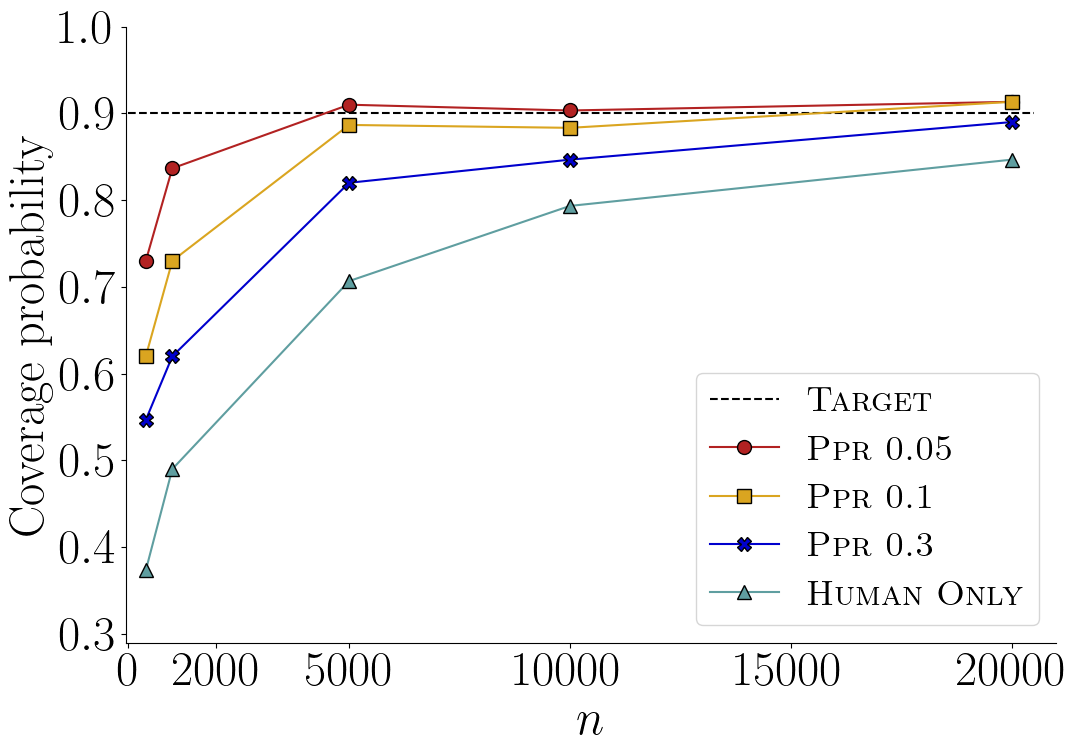

In [7]:
plot_coverage_n(cov_methods,n,alpha,methods)

### RBO

This code produces Figure 12.

In [8]:
def plot_rbo_n(avg_rbo, ci_rbo, n, alpha, methods,p):
    fig, ax = plt.subplots(figsize=(12, 8))
    for m in methods:
        if m=='baseline':
            continue
        if 'llm' in m:
            ax.plot(n,avg_rbo[m], label=label_mapping[m],color=color_mapping[m],linestyle=linestyles[m], markeredgecolor='black')
        else:
            ax.plot(n,avg_rbo[m], label=label_mapping[m], marker=marker_mapping[m],color=color_mapping[m], markeredgecolor='black')
        ax.fill_between(n,
                           [avg_rbo[m][i]-ci_rbo[m][i] for i in range(len(avg_rbo[m]))],
                           [avg_rbo[m][i]+ci_rbo[m][i] for i in range(len(avg_rbo[m]))],
                           color=color_mapping[m], alpha=0.3,edgecolor=color_mapping[m])
    ax.set_xlabel('$n$')
    ax.set_ylabel(f'RBO')
    ax.set_xlim(-50,21000)
    ax.set_ylim(0.55,1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([0,2000,5000,10000,15000,20000])
    ax.legend(ncol=2, fontsize=25,bbox_to_anchor=(0.23, 0.5), frameon=True)
    if not os.path.exists('../figures/synthetic'):
        os.makedirs('../figures/synthetic')
    plt.savefig(f'../figures/synthetic/rbo-n-p{p}.pdf', bbox_inches='tight')

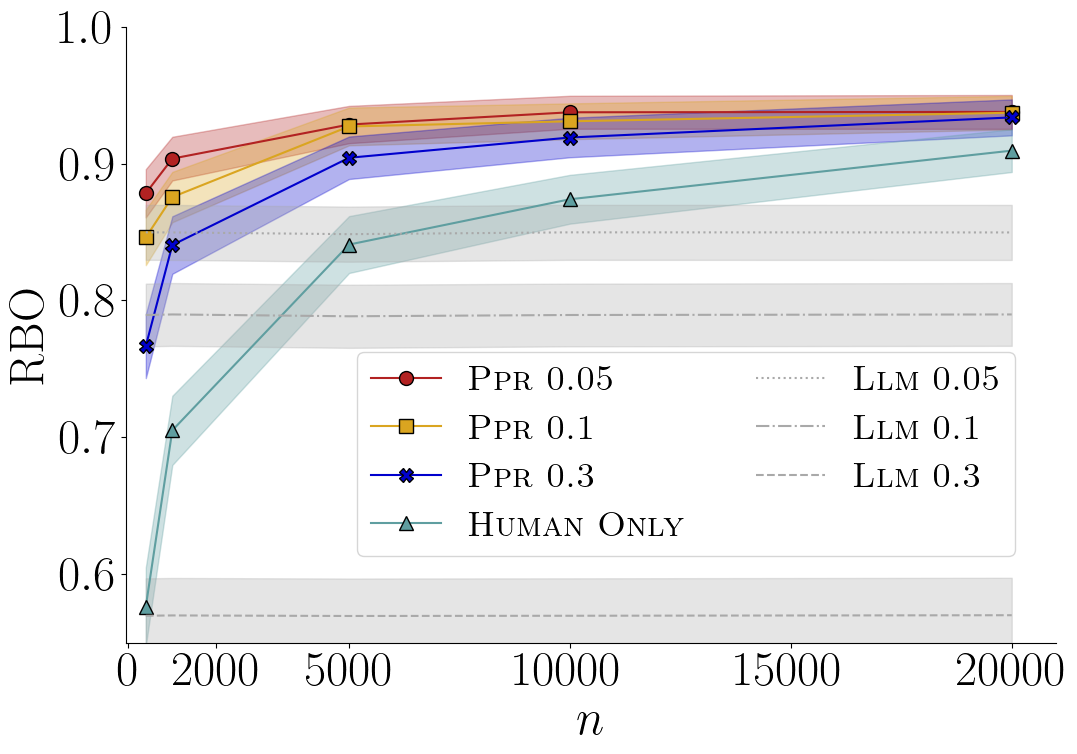

In [9]:
plot_rbo_n(rbo_avg_methods,rbo_ci_methods,n,alpha,methods,p=p)